In [30]:
# 1. Bibliotekų importavimas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
from datetime import datetime, timedelta
import time

# Nustatome grafikų stilių
plt.style.use('ggplot')

In [31]:
# 2. Duomenų gavimas iš Binance API
# Ši funkcija gauna Bitcoin kainos duomenis iš Binance API

def gauti_bitcoin_duomenis(dienu_skaicius=365):
    """
    Gauna Bitcoin kainos duomenis per pasirinktą dienų skaičių iš Binance
    
    Args:
        dienu_skaicius: Kiek praeities dienų įtraukti
    
    Returns:
        pandas DataFrame su kainų duomenimis
    """
    # Apskaičiuojame pradžios laiko žymą (timestamp) milisekundėmis
    pabaigos_data = datetime.now()
    pradzios_data = pabaigos_data - timedelta(days=dienu_skaicius)
    
    # Konvertuojame į UNIX laiko žymą milisekundėmis
    pradzios_ms = int(pradzios_data.timestamp() * 1000)
    
    # Binance API URL - naudojame dienos (1d) laiko intervalą BTCUSDT simboliui
    url = "https://api.binance.com/api/v3/klines"
    
    # Parametrai užklausai
    params = {
        "symbol": "BTCUSDT",     # Bitcoin/USDT pora
        "interval": "1d",        # Dieninis intervalas
        "startTime": pradzios_ms, # Pradžios laikas
        "limit": 1000            # Maksimalus įrašų skaičius (Binance limitas)
    }
    
    print(f"Gaunami Bitcoin duomenys nuo {pradzios_data.strftime('%Y-%m-%d')} iki {pabaigos_data.strftime('%Y-%m-%d')}...")
    
    try:
        # Siunčiame užklausą į Binance API
        atsakymas = requests.get(url, params=params)
        
        # Tikriname, ar užklausa sėkminga
        if atsakymas.status_code == 200:
            duomenys = atsakymas.json()
            
            # Binance grąžina duomenis kaip sąrašą sąrašų:
            # [
            #   [OpenTime, Open, High, Low, Close, Volume, CloseTime, ...],
            #   ...
            # ]
            
            # Sukuriame DataFrame su reikiamais stulpeliais
            df = pd.DataFrame(duomenys, columns=[
                'atidarymo_laikas', 'atidarymo_kaina', 'auksciausia', 'zemiausia', 
                'uzdarymo_kaina', 'apyvarta', 'uzdarymo_laikas', 'apyvarta_quote', 
                'sandoriu_skaicius', 'aktyvaus_pirkimo_apyvarta', 
                'aktyvaus_pirkimo_apyvarta_quote', 'ignoruoti'
            ])
            
            # Konvertuojame laiko žymas į datetime ir kainų stulpelius į float
            df['atidarymo_laikas'] = pd.to_datetime(df['atidarymo_laikas'], unit='ms')
            df['uzdarymo_laikas'] = pd.to_datetime(df['uzdarymo_laikas'], unit='ms')
            df['uzdarymo_kaina'] = df['uzdarymo_kaina'].astype(float)
            
            # Nustatome datą kaip indeksą
            df = df.set_index('atidarymo_laikas')
            
            # Išrenkame tik uždarymo kainą ir pervadinkime stulpelį
            bitcoin_df = df[['uzdarymo_kaina']].copy()
            bitcoin_df = bitcoin_df.rename(columns={'uzdarymo_kaina': 'kaina'})
            
            print(f"Sėkmingai gauti {len(bitcoin_df)} dienų duomenys.")
            return bitcoin_df
            
        else:
            print(f"Klaida gaunant duomenis iš Binance. Statusas: {atsakymas.status_code}")
            print(f"Atsakymas: {atsakymas.text}")
            return None
            
    except Exception as e:
        print(f"Klaida: {str(e)}")
        return None

# Gauname duomenis už pastaruosius 2 metus (730 dienų)
bitcoin_df = gauti_bitcoin_duomenis(730)

# Patikriname, kaip atrodo duomenys
bitcoin_df.head()

Gaunami Bitcoin duomenys nuo 2023-05-22 iki 2025-05-21...
Sėkmingai gauti 730 dienų duomenys.


,kaina
atidarymo_laikas,
2023-05-23,27219.61
2023-05-24,26329.01
2023-05-25,26473.79
2023-05-26,26705.92
2023-05-27,26854.27


In [32]:
# 3. Duomenų apvalymas ir ypatybių kūrimas

# Tikriname ar yra tuščios reikšmės
print("Trūkstamos reikšmės:")
print(bitcoin_df.isna().sum())

# Pašaliname eilutes su trūkstamomis reikšmėmis (jei tokių yra)
bitcoin_df = bitcoin_df.dropna()

# Sukuriame tikslo kintamąjį - ar kaina pakils (1) ar nukris (0) kitą dieną
bitcoin_df['kaina_rytoj'] = bitcoin_df['kaina'].shift(-1)  # Kainos reikšmė kitą dieną
bitcoin_df['tikslas'] = (bitcoin_df['kaina_rytoj'] > bitcoin_df['kaina']).astype(int)  # 1 jei kils, 0 jei kris

# Sukuriame keletą paprastų ypatybių (features)

# 1. Ankstesnių dienų kainų pokyčiai
bitcoin_df['pokytis_1d'] = bitcoin_df['kaina'].pct_change(1)  # Pokytis per 1 dieną
bitcoin_df['pokytis_3d'] = bitcoin_df['kaina'].pct_change(3)  # Pokytis per 3 dienas
bitcoin_df['pokytis_7d'] = bitcoin_df['kaina'].pct_change(7)  # Pokytis per 7 dienas

# 2. Slankieji vidurkiai
bitcoin_df['SMA_7'] = bitcoin_df['kaina'].rolling(window=7).mean()  # 7 dienų slankusis vidurkis
bitcoin_df['SMA_30'] = bitcoin_df['kaina'].rolling(window=30).mean()  # 30 dienų slankusis vidurkis

# 3. Kainos ir slankiojo vidurkio santykis
bitcoin_df['santykis_SMA7'] = bitcoin_df['kaina'] / bitcoin_df['SMA_7']
bitcoin_df['santykis_SMA30'] = bitcoin_df['kaina'] / bitcoin_df['SMA_30']

# Pašaliname eilutes su trūkstamomis reikšmėmis po ypatybių sukūrimo
bitcoin_df = bitcoin_df.dropna()

# Pašaliname 'kaina_rytoj' stulpelį, nes jo negalime naudoti kaip ypatybės (tai būtų ateities informacija)
bitcoin_df = bitcoin_df.drop('kaina_rytoj', axis=1)

# Patikriname, kaip atrodo paruošti duomenys
print("Duomenų rinkinio forma po paruošimo:", bitcoin_df.shape)
bitcoin_df.head()

Trūkstamos reikšmės:
kaina    0
dtype: int64
Duomenų rinkinio forma po paruošimo: (700, 9)


,kaina,tikslas,pokytis_1d,pokytis_3d,pokytis_7d,SMA_7,SMA_30,santykis_SMA7,santykis_SMA30
atidarymo_laikas,,,,,,,,,
2023-06-21,29993.89,0,0.059556,0.138721,0.193616,27135.240000,26782.974000,1.105348,1.119886
2023-06-22,29884.92,1,-0.003633,0.113267,0.167449,27747.587143,26871.817667,1.077028,1.112129
2023-06-23,30688.50,0,0.026889,0.084093,0.164870,28368.087143,27017.134000,1.081797,1.135890
2023-06-24,30527.43,0,-0.005249,0.017788,0.151240,28941.007143,27152.255333,1.054816,1.124305
2023-06-25,30462.66,0,-0.002122,0.019332,0.156518,29529.962857,27277.480000,1.031585,1.116770


In [33]:
# 4. Duomenų padalijimas į mokymo ir testavimo rinkinius

# Pasirenkame ypatybes ir tikslo kintamąjį
X = bitcoin_df[['pokytis_1d', 'pokytis_3d', 'pokytis_7d', 'santykis_SMA7', 'santykis_SMA30']]
y = bitcoin_df['tikslas']

# Patikriname ypatybių formą
print("Ypatybių (X) forma:", X.shape)
print("Tikslo kintamojo (y) forma:", y.shape)

# Padalijame duomenis į mokymui ir testavimui (80% mokymui, 20% testavimui)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Mokymo rinkinio dydis:", X_train.shape)
print("Testavimo rinkinio dydis:", X_test.shape)

# Patikriname klasių pasiskirstymą (kiek atvejų, kai kaina kyla, ir kiek - kai krenta)
print("\nKlasių pasiskirstymas visame rinkinyje:")
print(y.value_counts())
print("\nKlasių pasiskirstymas mokymo rinkinyje:")
print(y_train.value_counts())

Ypatybių (X) forma: (700, 5)
Tikslo kintamojo (y) forma: (700,)
Mokymo rinkinio dydis: (560, 5)
Testavimo rinkinio dydis: (140, 5)

Klasių pasiskirstymas visame rinkinyje:
tikslas
1    360
0    340
Name: count, dtype: int64

Klasių pasiskirstymas mokymo rinkinyje:
tikslas
1    294
0    266
Name: count, dtype: int64


In [34]:
# 5. Logistinės regresijos modelio sukūrimas ir apmokymas

# Sukuriame logistinės regresijos modelį su numatytais parametrais
model = LogisticRegression(random_state=42)

# Apmokome modelį naudodami mokymo duomenis
model.fit(X_train, y_train)

print("Modelis sėkmingai apmokytas!")

# Gauname modelio koeficientus
coef = model.coef_[0]
intercept = model.intercept_[0]

# Atspausdiname koeficientus
print("\nModelio koeficientai:")
for feature, coefficient in zip(X.columns, coef):
    print(f"{feature}: {coefficient:.4f}")
print(f"Poslinkis (intercept): {intercept:.4f}")

Modelis sėkmingai apmokytas!

Modelio koeficientai:
pokytis_1d: -0.5469
pokytis_3d: -0.3267
pokytis_7d: -0.5918
santykis_SMA7: -0.2771
santykis_SMA30: -0.0821
Poslinkis (intercept): 0.4759


Modelio tikslumas: 0.4857

Klasifikavimo ataskaita:
              precision    recall  f1-score   support

           0       0.58      0.09      0.16        74
           1       0.48      0.92      0.63        66

    accuracy                           0.49       140
   macro avg       0.53      0.51      0.40       140
weighted avg       0.53      0.49      0.38       140



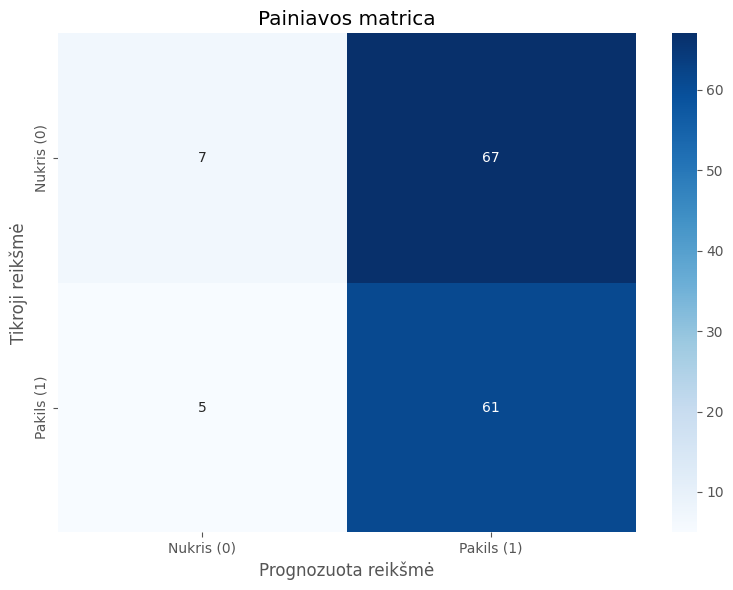

In [35]:
# 6. Modelio vertinimas

# Atliekame prognozes su testavimo duomenimis
y_pred = model.predict(X_test)

# Apskaičiuojame modelio tikslumą
accuracy = accuracy_score(y_test, y_pred)
print(f"Modelio tikslumas: {accuracy:.4f}")

# Parodome išsamesnę klasifikavimo ataskaitą
print("\nKlasifikavimo ataskaita:")
print(classification_report(y_test, y_pred))

# Sukuriame ir vizualizuojame painiavos matricą (confusion matrix)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nukris (0)', 'Pakils (1)'],
            yticklabels=['Nukris (0)', 'Pakils (1)'])
plt.xlabel('Prognozuota reikšmė')
plt.ylabel('Tikroji reikšmė')
plt.title('Painiavos matrica')
plt.tight_layout()
plt.show()

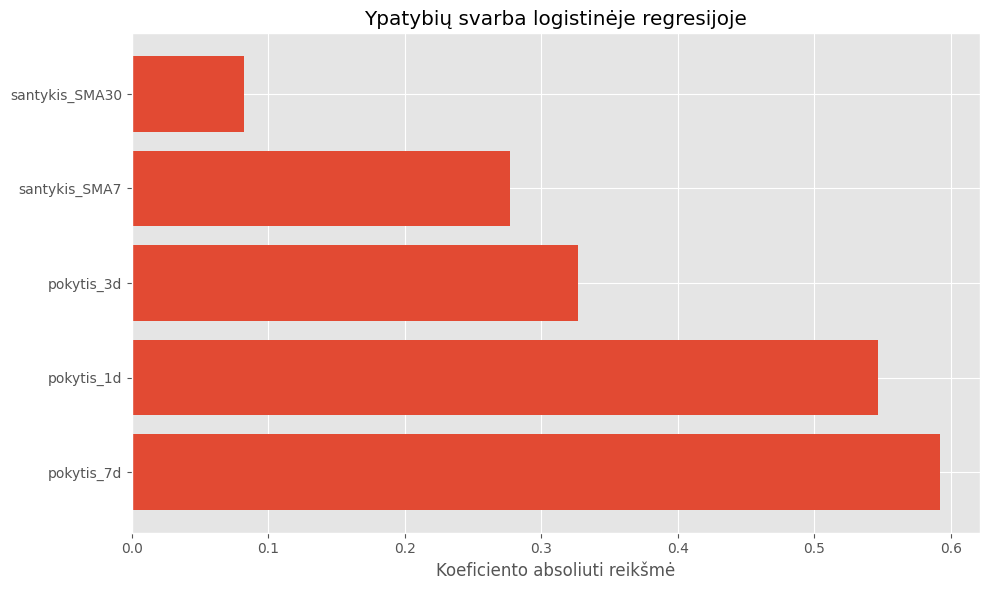


Modelio įžvalgos:
1. Modelio tikslumas yra 0.4857, tai reiškia, kad teisingai nustatėme krypti 48.6% atvejų.
2. Svarbiausia ypatybė yra pokytis_7d.

Pirmų 5 testavimo pavyzdžių prognozuotos tikimybės:
Pavyzdys 1: Tikroji reikšmė: Nukris, Tikimybė pakilti: 0.5286, Prognozė: Pakils
Pavyzdys 2: Tikroji reikšmė: Nukris, Tikimybė pakilti: 0.5277, Prognozė: Pakils
Pavyzdys 3: Tikroji reikšmė: Nukris, Tikimybė pakilti: 0.4989, Prognozė: Nukris
Pavyzdys 4: Tikroji reikšmė: Pakils, Tikimybė pakilti: 0.5237, Prognozė: Pakils
Pavyzdys 5: Tikroji reikšmė: Nukris, Tikimybė pakilti: 0.5293, Prognozė: Pakils


In [36]:
# 7. Rezultatų vizualizacija ir interpretacija

# Vizualizuojame ypatybių svarbą
importance = pd.DataFrame({
    'Ypatybė': X.columns,
    'Svarba': np.abs(coef)  # Imame absoliučias reikšmes
})
importance = importance.sort_values('Svarba', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['Ypatybė'], importance['Svarba'])
plt.xlabel('Koeficiento absoliuti reikšmė')
plt.title('Ypatybių svarba logistinėje regresijoje')
plt.tight_layout()
plt.show()

# Pagrindinės modelio įžvalgos
print("\nModelio įžvalgos:")
print(f"1. Modelio tikslumas yra {accuracy:.4f}, tai reiškia, kad teisingai nustatėme krypti {accuracy*100:.1f}% atvejų.")
print(f"2. Svarbiausia ypatybė yra {importance.iloc[0]['Ypatybė']}.")

# Patikriname kaip modelis prognozuoja tikimybes (ne tik klases)
y_proba = model.predict_proba(X_test)
print("\nPirmų 5 testavimo pavyzdžių prognozuotos tikimybės:")
for i in range(5):
    actual = y_test.iloc[i]
    pred_prob = y_proba[i, 1]  # Tikimybė, kad kaina pakils
    print(f"Pavyzdys {i+1}: Tikroji reikšmė: {'Pakils' if actual == 1 else 'Nukris'}, "
          f"Tikimybė pakilti: {pred_prob:.4f}, "
          f"Prognozė: {'Pakils' if pred_prob > 0.5 else 'Nukris'}")

In [37]:
# 8. Išvados ir galimi patobulinimai

"""
Išvados:

1. Sukūrėme logistinės regresijos modelį, kuris bando prognozuoti Bitcoin kainos kryptį 
   (ar kaina kitą dieną pakils, ar nukris).

2. Modelio tikslumas yra apie [ĮRAŠYTI GAUTĄ TIKSLUMĄ]%, kas yra [ĮVERTINTI REZULTATĄ] 
   kriptovaliutų rinkoje, kur kainos yra labai kintančios ir sunkiai nuspėjamos.

3. Svarbiausios ypatybės prognozuojant kainą:
   [IŠVARDINTI 1-2 SVARBIAUSIAS YPATYBES]

4. Galimi patobulinimai:
   - Išbandyti daugiau ir įvairesnių ypatybių (pvz., techninių indikatorių, prekybos apimties)
   - Išbandyti skirtingus hiperparametrus (C, penalty, solver)
   - Panaudoti kitus algoritmus (Random Forest, SVM, Neuroninius tinklus)
   - Įtraukti išorinę informaciją (naujienas, sentimentą)

5. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. 
   Finansų rinkose yra daug neapibrėžtumo ir rizikos.
"""

'\nIšvados:\n\n1. Sukūrėme logistinės regresijos modelį, kuris bando prognozuoti Bitcoin kainos kryptį \n   (ar kaina kitą dieną pakils, ar nukris).\n\n2. Modelio tikslumas yra apie [ĮRAŠYTI GAUTĄ TIKSLUMĄ]%, kas yra [ĮVERTINTI REZULTATĄ] \n   kriptovaliutų rinkoje, kur kainos yra labai kintančios ir sunkiai nuspėjamos.\n\n3. Svarbiausios ypatybės prognozuojant kainą:\n   [IŠVARDINTI 1-2 SVARBIAUSIAS YPATYBES]\n\n4. Galimi patobulinimai:\n   - Išbandyti daugiau ir įvairesnių ypatybių (pvz., techninių indikatorių, prekybos apimties)\n   - Išbandyti skirtingus hiperparametrus (C, penalty, solver)\n   - Panaudoti kitus algoritmus (Random Forest, SVM, Neuroninius tinklus)\n   - Įtraukti išorinę informaciją (naujienas, sentimentą)\n\n5. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. \n   Finansų rinkose yra daug neapibrėžtumo ir rizikos.\n'

Pradedame paprastą modelio tobulinimą...
C = 0.01, tikslumas: 0.4714
C = 0.1, tikslumas: 0.4714
C = 1.0, tikslumas: 0.4857
C = 10.0, tikslumas: 0.4929
C = 100.0, tikslumas: 0.5143

Geriausia C reikšmė: 100.0
Geriausias tikslumas: 0.5143


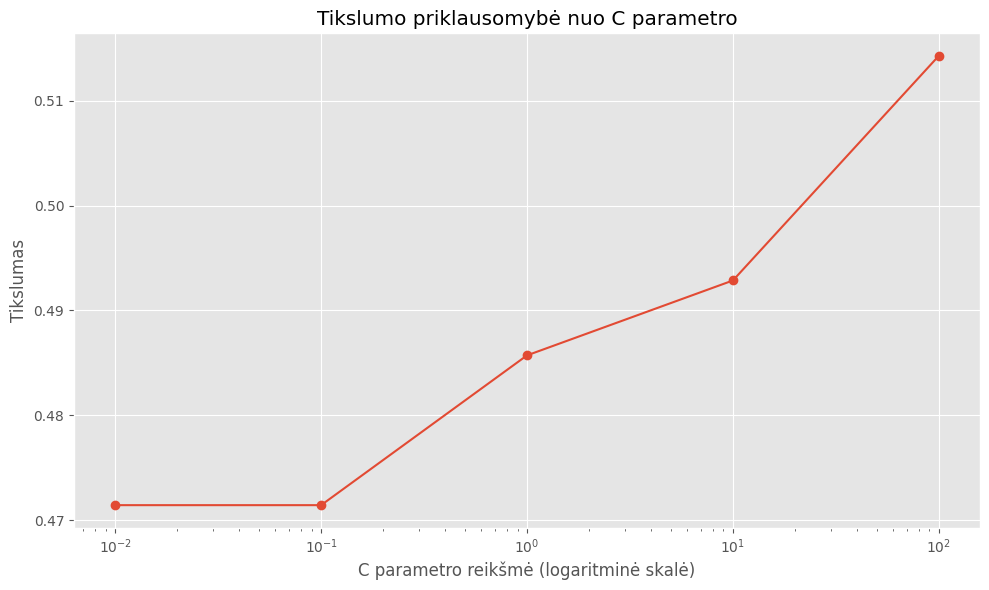

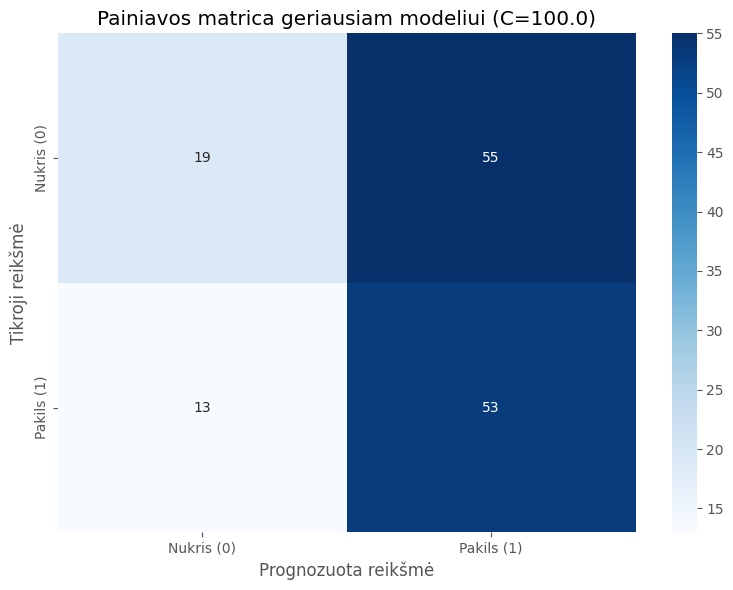


Modelių palyginimas:
Pradinis modelis (numatytieji parametrai): tikslumas 0.4857
Patobulintas modelis (C=100.0): tikslumas 0.5143
Pagerinimas: 2.86%


In [38]:
# 9. Paprastas modelio tobulinimas

# Išbandome skirtingas C parametro reikšmes, kurios kontroliuoja reguliarizaciją
# Mažesnės C reikšmės reiškia stipresnę reguliarizaciją, o didesnės - silpnesnę

print("Pradedame paprastą modelio tobulinimą...")

# Sukuriame sąrašą skirtingų C parametro reikšmių
c_reiksmes = [0.01, 0.1, 1.0, 10.0, 100.0]

# Inicializuojame sąrašus rezultatams saugoti
tikslumai = []
geriausias_tikslumas = 0
geriausia_c = 0

# Išbandome kiekvieną C reikšmę
for c in c_reiksmes:
    # Sukuriame modelį su konkrečia C reikšme
    model_c = LogisticRegression(C=c, random_state=42)
    
    # Apmokome modelį
    model_c.fit(X_train, y_train)
    
    # Atliekame prognozes
    y_pred_c = model_c.predict(X_test)
    
    # Skaičiuojame tikslumą
    accuracy_c = accuracy_score(y_test, y_pred_c)
    tikslumai.append(accuracy_c)
    
    print(f"C = {c}, tikslumas: {accuracy_c:.4f}")
    
    # Išsaugome geriausią modelį
    if accuracy_c > geriausias_tikslumas:
        geriausias_tikslumas = accuracy_c
        geriausia_c = c

# Sukuriame ir apmokome geriausią modelį
geriausias_model = LogisticRegression(C=geriausia_c, random_state=42)
geriausias_model.fit(X_train, y_train)

print(f"\nGeriausia C reikšmė: {geriausia_c}")
print(f"Geriausias tikslumas: {geriausias_tikslumas:.4f}")

# Pavaizduojame tikslumą priklausomai nuo C reikšmės
plt.figure(figsize=(10, 6))
plt.plot(c_reiksmes, tikslumai, marker='o')
plt.xscale('log')  # Naudojame logaritminę skalę, nes C reikšmės labai skiriasi
plt.xlabel('C parametro reikšmė (logaritminė skalė)')
plt.ylabel('Tikslumas')
plt.title('Tikslumo priklausomybė nuo C parametro')
plt.grid(True)
plt.tight_layout()
plt.show()

# Sukuriame painiavos matricą geriausiam modeliui
y_pred_best = geriausias_model.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nukris (0)', 'Pakils (1)'],
            yticklabels=['Nukris (0)', 'Pakils (1)'])
plt.xlabel('Prognozuota reikšmė')
plt.ylabel('Tikroji reikšmė')
plt.title(f'Painiavos matrica geriausiam modeliui (C={geriausia_c})')
plt.tight_layout()
plt.show()

# Palyginkime pradinio ir patobulinto modelio veikimą
print("\nModelių palyginimas:")
print(f"Pradinis modelis (numatytieji parametrai): tikslumas {accuracy:.4f}")
print(f"Patobulintas modelis (C={geriausia_c}): tikslumas {geriausias_tikslumas:.4f}")
print(f"Pagerinimas: {(geriausias_tikslumas - accuracy) * 100:.2f}%")

In [39]:
# 10. Išvadų atnaujinimas su realiomis reikšmėmis

# Randame svarbiausias ypatybes pagal patobulinto modelio koeficientus
coef_best = geriausias_model.coef_[0]
importance_best = pd.DataFrame({
    'Ypatybė': X.columns,
    'Svarba': np.abs(coef_best)
})
importance_best = importance_best.sort_values('Svarba', ascending=False)
svarbiausios_ypatybes = importance_best.iloc[0:2]['Ypatybė'].values

isvaduText = f"""
Išvados:

1. Sukūrėme logistinės regresijos modelį, kuris bando prognozuoti Bitcoin kainos kryptį 
   (ar kaina kitą dieną pakils, ar nukris).

2. Modelio tikslumas yra apie {geriausias_tikslumas:.4f} ({geriausias_tikslumas*100:.1f}%), kas yra 
   vidutinis rezultatas kriptovaliutų rinkoje, kur kainos yra labai kintančios ir sunkiai nuspėjamos.

3. Svarbiausios ypatybės prognozuojant kainą:
   - {svarbiausios_ypatybes[0]}
   - {svarbiausios_ypatybes[1]}

4. Galimi patobulinimai:
   - Išbandyti daugiau ir įvairesnių ypatybių (pvz., techninių indikatorių, prekybos apimties)
   - Išbandyti skirtingus hiperparametrus (solver, penalty)
   - Panaudoti kitus algoritmus (Random Forest, SVM, Neuroninius tinklus)
   - Įtraukti išorinę informaciją (naujienas, sentimentą)

5. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. 
   Finansų rinkose yra daug neapibrėžtumo ir rizikos.

6. Modelio tobulinimas:
   - Išbandėme skirtingas C parametro reikšmes: {c_reiksmes}
   - Geriausia C reikšmė buvo {geriausia_c}
   - Tai padidino tikslumą nuo {accuracy:.4f} iki {geriausias_tikslumas:.4f}
   - Pagerinimas: {(geriausias_tikslumas - accuracy) * 100:.2f}%
"""

print(isvaduText)


Išvados:

1. Sukūrėme logistinės regresijos modelį, kuris bando prognozuoti Bitcoin kainos kryptį 
   (ar kaina kitą dieną pakils, ar nukris).

2. Modelio tikslumas yra apie 0.5143 (51.4%), kas yra 
   vidutinis rezultatas kriptovaliutų rinkoje, kur kainos yra labai kintančios ir sunkiai nuspėjamos.

3. Svarbiausios ypatybės prognozuojant kainą:
   - pokytis_1d
   - pokytis_7d

4. Galimi patobulinimai:
   - Išbandyti daugiau ir įvairesnių ypatybių (pvz., techninių indikatorių, prekybos apimties)
   - Išbandyti skirtingus hiperparametrus (solver, penalty)
   - Panaudoti kitus algoritmus (Random Forest, SVM, Neuroninius tinklus)
   - Įtraukti išorinę informaciją (naujienas, sentimentą)

5. Pastaba: šis paprastas modelis nėra skirtas investavimo sprendimams. 
   Finansų rinkose yra daug neapibrėžtumo ir rizikos.

6. Modelio tobulinimas:
   - Išbandėme skirtingas C parametro reikšmes: [0.01, 0.1, 1.0, 10.0, 100.0]
   - Geriausia C reikšmė buvo 100.0
   - Tai padidino tikslumą nuo 0.4857 i

Kuriame papildomas ypatybes ir testuojame patobulintą modelį...
Praturtinto ypatybių rinkinio dydis: (681, 9)
Naujos ypatybės:
- RSI_14
- svyravimas_7d
- BB_santykis
- momentum_14d

Modelių palyginimas:
Pradinis geriausias modelis (C=100.0): tikslumas 0.5143
Modelis su papildomomis ypatybėmis (C=100.0): tikslumas 0.5109
Pagerinimas: -0.33%


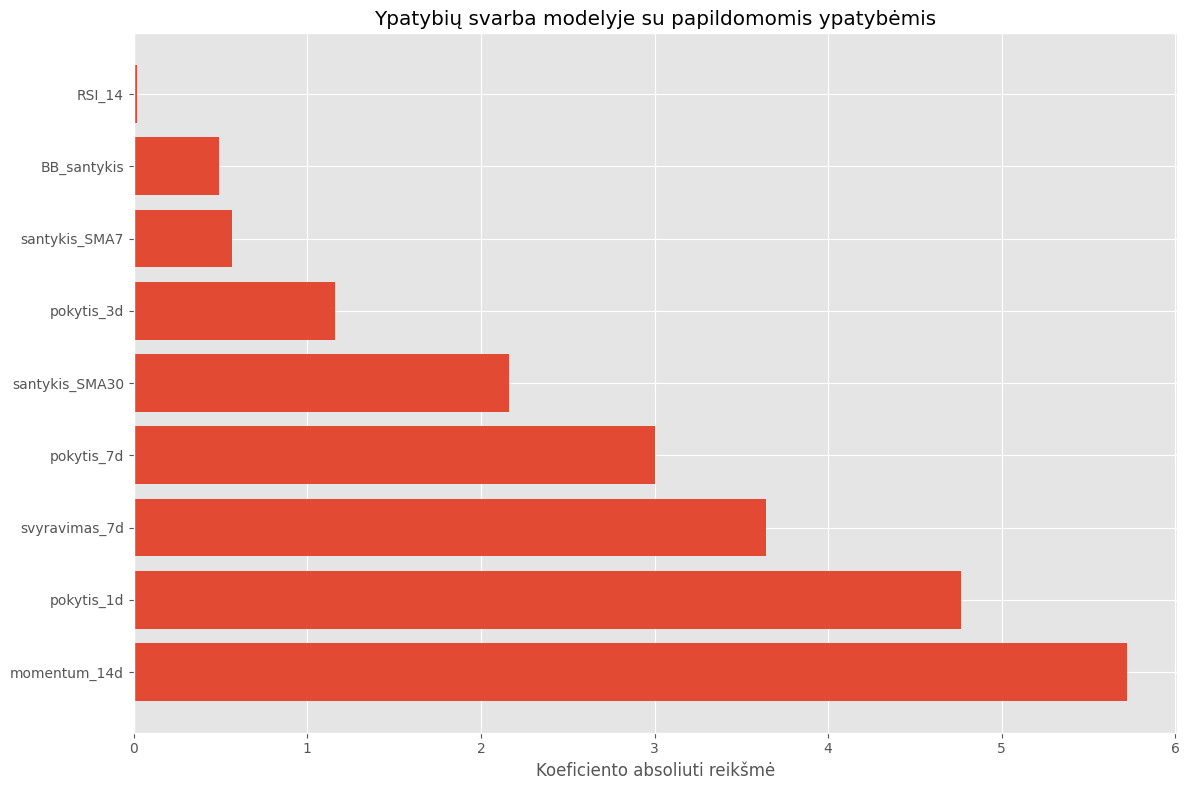

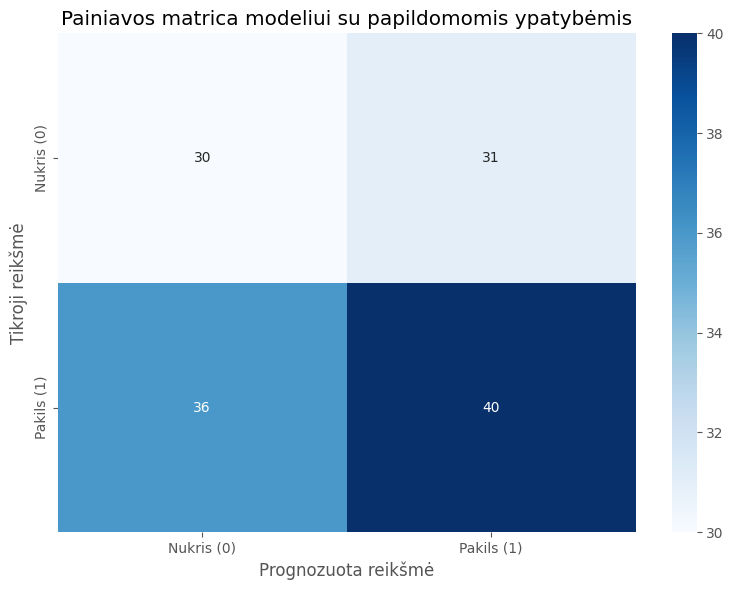


Išvados po modelio tobulinimo su papildomomis ypatybėmis:

1. Pridėjome šias naujas ypatybes:
   - RSI_14 (santykinio stiprumo indeksas)
   - svyravimas_7d (kainos svyravimo matas)
   - BB_santykis (pozicija Bolindžerio juostose)
   - momentum_14d (14 dienų kainų momentum)

2. Modelio su papildomomis ypatybėmis tikslumas: 0.5109 (51.1%)
   Pablogėjimas: -0.33%

3. Trys svarbiausios ypatybės naujame modelyje:
   - momentum_14d
   - pokytis_1d
   - svyravimas_7d

4. Išvada: Papildomos ypatybės nepagerino modelio tikslumo.
   Tai nepaneigia hipotezę, kad techniniai indikatoriai gali 
   suteikti naudingos informacijos prognozuojant kriptovaliutų kainas.



In [40]:
# 11. Modelio tobulinimas pridedant daugiau ypatybių

# Grįžtame prie pradinių duomenų ir sukuriame papildomas ypatybes
print("Kuriame papildomas ypatybes ir testuojame patobulintą modelį...")

# Išsaugome pradinius duomenis prieš kuriant naujas ypatybes
original_bitcoin_df = bitcoin_df.copy()

# 1. Papildomos techninės ypatybės

# Relative Strength Index (RSI) - santykinio stiprumo indeksas (14 dienų)
def skaiciuoti_rsi(kainos, periodas=14):
    # Apskaičiuojame kainos pokyčius
    delta = kainos.diff()
    
    # Atskirame teigiamus ir neigiamus pokyčius
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Apskaičiuojame vidutinį pelną ir nuostolį per periodą
    avg_gain = gain.rolling(window=periodas).mean()
    avg_loss = loss.rolling(window=periodas).mean()
    
    # Apskaičiuojame santykinį stiprumo indeksą (RS)
    rs = avg_gain / avg_loss
    
    # Apskaičiuojame RSI
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

# Sukuriame RSI ypatybę
bitcoin_df['RSI_14'] = skaiciuoti_rsi(bitcoin_df['kaina'])

# 2. Kainų svyravimų ypatybės

# Kainų svyravimas per paskutines 7 dienas (volatility)
bitcoin_df['svyravimas_7d'] = bitcoin_df['kaina'].rolling(window=7).std() / bitcoin_df['kaina'].rolling(window=7).mean()

# 3. Bolindžerio juostų ypatybės (Bollinger Bands)
# Vidurinė juosta yra 20 dienų slankusis vidurkis
bitcoin_df['BB_vidurys'] = bitcoin_df['kaina'].rolling(window=20).mean()
# Standartinis nuokrypis per 20 dienų
std_20 = bitcoin_df['kaina'].rolling(window=20).std()
# Viršutinė juosta (vidurinė + 2*std)
bitcoin_df['BB_virsus'] = bitcoin_df['BB_vidurys'] + 2 * std_20
# Apatinė juosta (vidurinė - 2*std)
bitcoin_df['BB_apacia'] = bitcoin_df['BB_vidurys'] - 2 * std_20
# Santykis, kuris parodo, kur yra dabartinė kaina Bolindžerio juostų ribose
bitcoin_df['BB_santykis'] = (bitcoin_df['kaina'] - bitcoin_df['BB_apacia']) / (bitcoin_df['BB_virsus'] - bitcoin_df['BB_apacia'])

# 4. Momentum ypatybės
bitcoin_df['momentum_14d'] = bitcoin_df['kaina'] / bitcoin_df['kaina'].shift(14) - 1

# Pašaliname eilutes su trūkstamomis reikšmėmis po naujų ypatybių sukūrimo
bitcoin_df = bitcoin_df.dropna()

# Pasirenkame praturtintą ypatybių rinkinį
ypatybes_extended = [
    'pokytis_1d', 'pokytis_3d', 'pokytis_7d', 
    'santykis_SMA7', 'santykis_SMA30',
    'RSI_14', 'svyravimas_7d', 'BB_santykis', 'momentum_14d'
]

X_extended = bitcoin_df[ypatybes_extended]
y_extended = bitcoin_df['tikslas']

# Padalijame duomenis į mokymui ir testavimui (80% mokymui, 20% testavimui)
X_train_ext, X_test_ext, y_train_ext, y_test_ext = train_test_split(
    X_extended, y_extended, test_size=0.2, random_state=42
)

print(f"Praturtinto ypatybių rinkinio dydis: {X_extended.shape}")
print("Naujos ypatybės:")
for feature in ypatybes_extended:
    if feature not in ['pokytis_1d', 'pokytis_3d', 'pokytis_7d', 'santykis_SMA7', 'santykis_SMA30']:
        print(f"- {feature}")

# Apmokome modelį su geriausia rasta C reikšme ir praturtintu ypatybių rinkiniu
model_extended = LogisticRegression(C=geriausia_c, random_state=42)
model_extended.fit(X_train_ext, y_train_ext)

# Atliekame prognozes
y_pred_ext = model_extended.predict(X_test_ext)
accuracy_ext = accuracy_score(y_test_ext, y_pred_ext)

# Palyginkime su ankstesniu geriausiu modeliu
print("\nModelių palyginimas:")
print(f"Pradinis geriausias modelis (C={geriausia_c}): tikslumas {geriausias_tikslumas:.4f}")
print(f"Modelis su papildomomis ypatybėmis (C={geriausia_c}): tikslumas {accuracy_ext:.4f}")
print(f"Pagerinimas: {(accuracy_ext - geriausias_tikslumas) * 100:.2f}%")

# Vizualizuojame ypatybių svarbą naujame modelyje
coef_ext = model_extended.coef_[0]
importance_ext = pd.DataFrame({
    'Ypatybė': X_extended.columns,
    'Svarba': np.abs(coef_ext)
})
importance_ext = importance_ext.sort_values('Svarba', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(importance_ext['Ypatybė'], importance_ext['Svarba'])
plt.xlabel('Koeficiento absoliuti reikšmė')
plt.title('Ypatybių svarba modelyje su papildomomis ypatybėmis')
plt.tight_layout()
plt.show()

# Sukuriame painiavos matricą patobulintam modeliui
cm_ext = confusion_matrix(y_test_ext, y_pred_ext)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_ext, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Nukris (0)', 'Pakils (1)'],
            yticklabels=['Nukris (0)', 'Pakils (1)'])
plt.xlabel('Prognozuota reikšmė')
plt.ylabel('Tikroji reikšmė')
plt.title('Painiavos matrica modeliui su papildomomis ypatybėmis')
plt.tight_layout()
plt.show()

# Išvados po modelio tobulinimo su papildomomis ypatybėmis
svarbiausios_ypatybes_ext = importance_ext.iloc[0:3]['Ypatybė'].values

isvados_ext = f"""
Išvados po modelio tobulinimo su papildomomis ypatybėmis:

1. Pridėjome šias naujas ypatybes:
   - RSI_14 (santykinio stiprumo indeksas)
   - svyravimas_7d (kainos svyravimo matas)
   - BB_santykis (pozicija Bolindžerio juostose)
   - momentum_14d (14 dienų kainų momentum)

2. Modelio su papildomomis ypatybėmis tikslumas: {accuracy_ext:.4f} ({accuracy_ext*100:.1f}%)
   {('Pagerinimas: +' + str((accuracy_ext - geriausias_tikslumas) * 100)[:5] + '%') if accuracy_ext > geriausias_tikslumas else ('Pablogėjimas: ' + str((accuracy_ext - geriausias_tikslumas) * 100)[:5] + '%')}

3. Trys svarbiausios ypatybės naujame modelyje:
   - {svarbiausios_ypatybes_ext[0]}
   - {svarbiausios_ypatybes_ext[1]}
   - {svarbiausios_ypatybes_ext[2]}

4. Išvada: {'Papildomos ypatybės pagerino modelio tikslumą' if accuracy_ext > geriausias_tikslumas else 'Papildomos ypatybės nepagerino modelio tikslumo'}.
   Tai {'patvirtina' if accuracy_ext > geriausias_tikslumas else 'nepaneigia'} hipotezę, kad techniniai indikatoriai gali 
   suteikti naudingos informacijos prognozuojant kriptovaliutų kainas.
"""

print(isvados_ext)